# Package

In [1]:
import numpy as np

import os
import datetime
import netCDF4 as nc
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
"""
data = nc.Dataset("/work/b08209033/preprocess_ERA5/preprocess_zero_zonalmean_UV.nc")
v = data["v"][:,:,:,-1]
pressure = data["plev"][:]
lon = data["lon"][:]
lat = data["lat"][:]
lons, lats = np.meshgrid(lon, lat)

r = 6371*1e3
g = 9.81
weighting = 2*np.pi*r*np.cos(np.deg2rad(lat))/g

pressure_grad = np.diff(np.insert(pressure,0,0))
mean_v = np.insert(v,0,0, axis=1)
mean_v = (mean_v[:,:-1,:] + mean_v[:,1:,:])/2
streamfunc = np.cumsum(np.swapaxes(np.swapaxes(mean_v,1,-1)*pressure_grad, -1, 1)*weighting,axis = 1)

plt.figure(figsize=(16,9),dpi=160)
tmp = np.mean(streamfunc,axis = 0)
print(tmp.mean())
plt.gca().invert_yaxis()
plt.contour(lat,pressure,tmp, levels = 16, colors = "k")
plt.xticks(np.linspace(-90,90,7))
plt.xlabel("latitude")
plt.ylabel("pressure")
"""

In [5]:
data = nc.Dataset("/work/b08209033/preprocess_ERA5/preprocess_U_850.nc")
u = data["u"][:,-1,:,:]
lon = data["lon"][:]
lat = data["lat"][:]
lons, lats = np.meshgrid(lon, lat)

In [6]:
south_zonal_wind = np.mean(u[:, (lat>5) & (lat<15), :][:,:, (lon>40)&(lon<80)], axis = (1,2))
north_zonal_wind = np.mean(u[:, (lat>20) & (lat<30), :][:,:, (lon>70)&(lon<90)], axis = (1,2))

In [13]:
MOVING_LEN = 28

WWL_index = south_zonal_wind-north_zonal_wind
WWL_index_smooth = np.convolve(WWL_index, np.ones(MOVING_LEN)/MOVING_LEN, mode='same')
WWL_index_grad = np.gradient(WWL_index_smooth)
WWL_index = np.reshape(WWL_index, (43,-1))
WWL_index_smooth = np.reshape(WWL_index_smooth, (43,-1))
WWL_index_grad = np.reshape(WWL_index_grad, (43,-1))

onset_date_index = np.argmax(WWL_index_smooth >= 0, axis = 1)

warn_count = 0
print(f"Moving length -> {MOVING_LEN}")
for i,index in enumerate(onset_date_index):
    #print(f"year -> {i+1979} date -> {index}")
    if (index<135 or index>165):
        warn_count += 1
        #print("Warning")
print(warn_count)
print(onset_date_index)


Moving length -> 28
14
[153 142 134 142 150 141 135 140 146 131 133 128 144 147 143 140 135 145
 156 139 126 127 131 132 145 122 147 133 130 137 135 137 138 139 134 143
 141 134 137 137 148 135 127]


In [17]:
os.chdir("/home/b08209033/IndianMonsoon/Detect")
df = pd.read_csv("TropicalCycloneCount.csv", 
                 sep="\t", 
                 on_bad_lines='skip', 
                 header=None)
df.columns = ["Year", "Month", "Day", "Occurrence", "Time"]
df = df.astype(int)
occurrence = df[df.columns[3]].to_numpy()
occurrence_smooth = np.convolve(occurrence, np.ones(MOVING_LEN)/MOVING_LEN, mode = "same")
occurrence_smooth = occurrence_smooth.reshape(43,-1)

Text(0.5, 1.0, 'TC_occurrence')

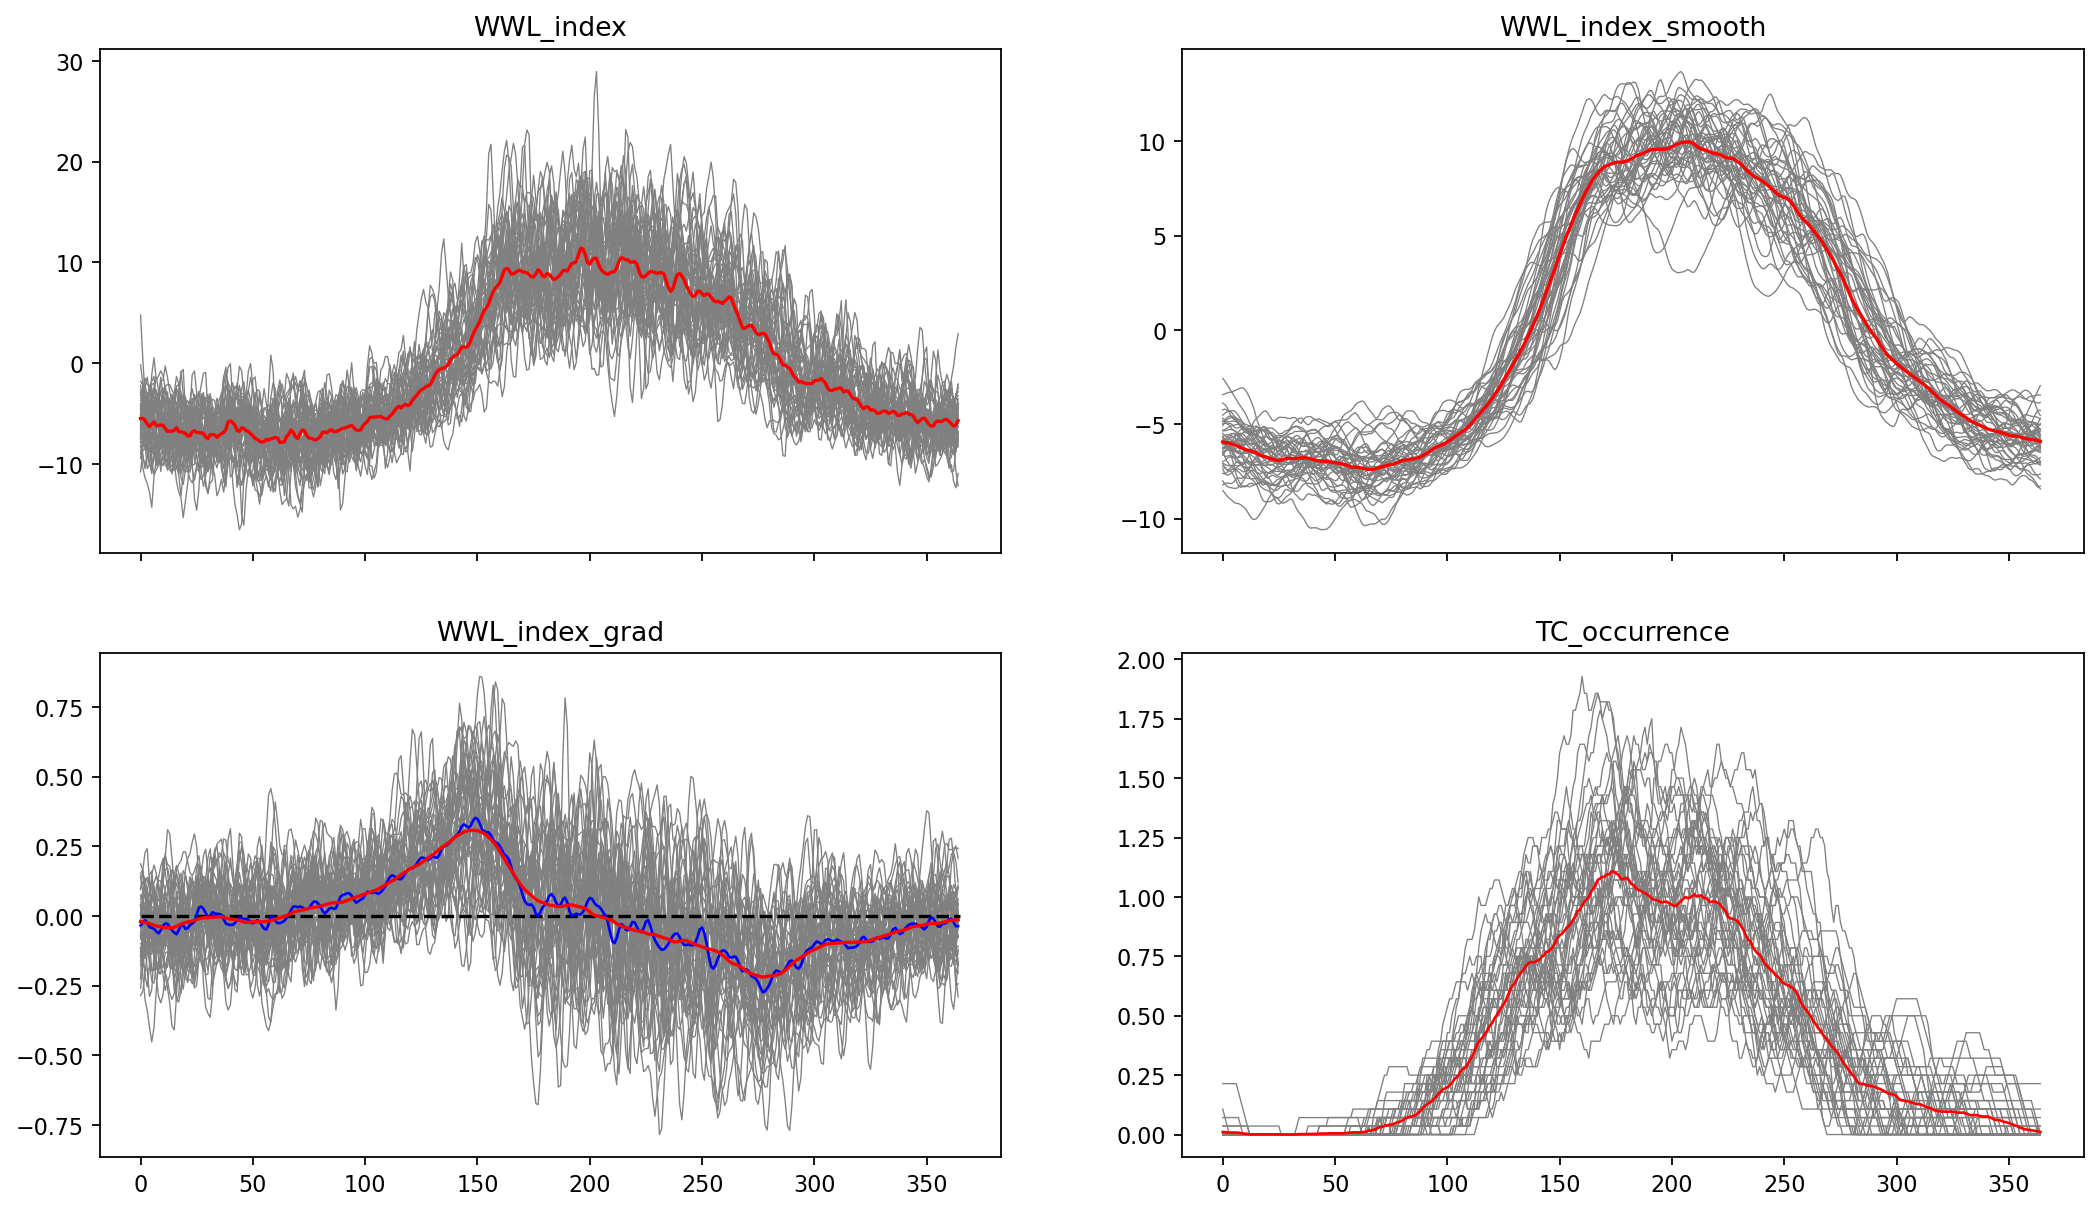

In [18]:
fig, axes = plt.subplots(nrows = 2, ncols = 2,
                         figsize = (16,9), dpi = 160,
                         sharex = True)
for i in range(43):
    axes[0,0].plot(WWL_index[i], color = "gray", lw = 0.6)
axes[0,0].plot(np.mean(WWL_index, axis=0), color = "red")
#axes[0,0].set_xlabel("Days since 01/01")
#axes[0,0].set_ylabel("WWL_index")
axes[0,0].set_title("WWL_index")

for i in range(43):
    axes[0,1].plot(WWL_index_smooth[i], color = "gray", lw = 0.6)
axes[0,1].plot(np.mean(WWL_index_smooth, axis=0), color = "red")
#axes[0,1].set_xlabel("Days since 01/01")
#axes[0,1].set_ylabel("WWL_index_smooth")
axes[0,1].set_title("WWL_index_smooth")

for i in range(43):
    axes[1,0].plot(WWL_index_grad[i], color = "gray", lw = 0.6)
axes[1,0].plot([0,365],[0,0], "k--")
axes[1,0].plot(np.mean(WWL_index_grad, axis=0), color = "b", lw = 1.2)
axes[1,0].plot(np.convolve(np.mean(WWL_index_grad, axis=0), np.ones(21)/21, mode='same'), color = "red", lw = 1.5)
# axes[1,0].set_xlabel("Days since 01/01")
# axes[1,0].set_ylabel("WWL_index_grad")
axes[1,0].set_title("WWL_index_grad")

for i in range(43):
    axes[1,1].plot(occurrence_smooth[i], color = "gray", lw = 0.6)
axes[1,1].plot(np.mean(occurrence_smooth, axis=0), color = "r", lw = 1.2)
# axes[1,0].set_xlabel("Days since 01/01")
# axes[1,0].set_ylabel("WWL_index_grad")
axes[1,1].set_title("TC_occurrence")

[138 157 163 166 159 155 134 146 155 139 144 136 139 161 167 154 155 142
 159 154 138 134 141 140 139 138 169 166 155 130 145 138 163 155 150 154
 157 151 162 160 163 157 146]
[[1.         0.40124312]
 [0.40124312 1.        ]]


Text(0, 0.5, 'onset date (cumulative TC)')

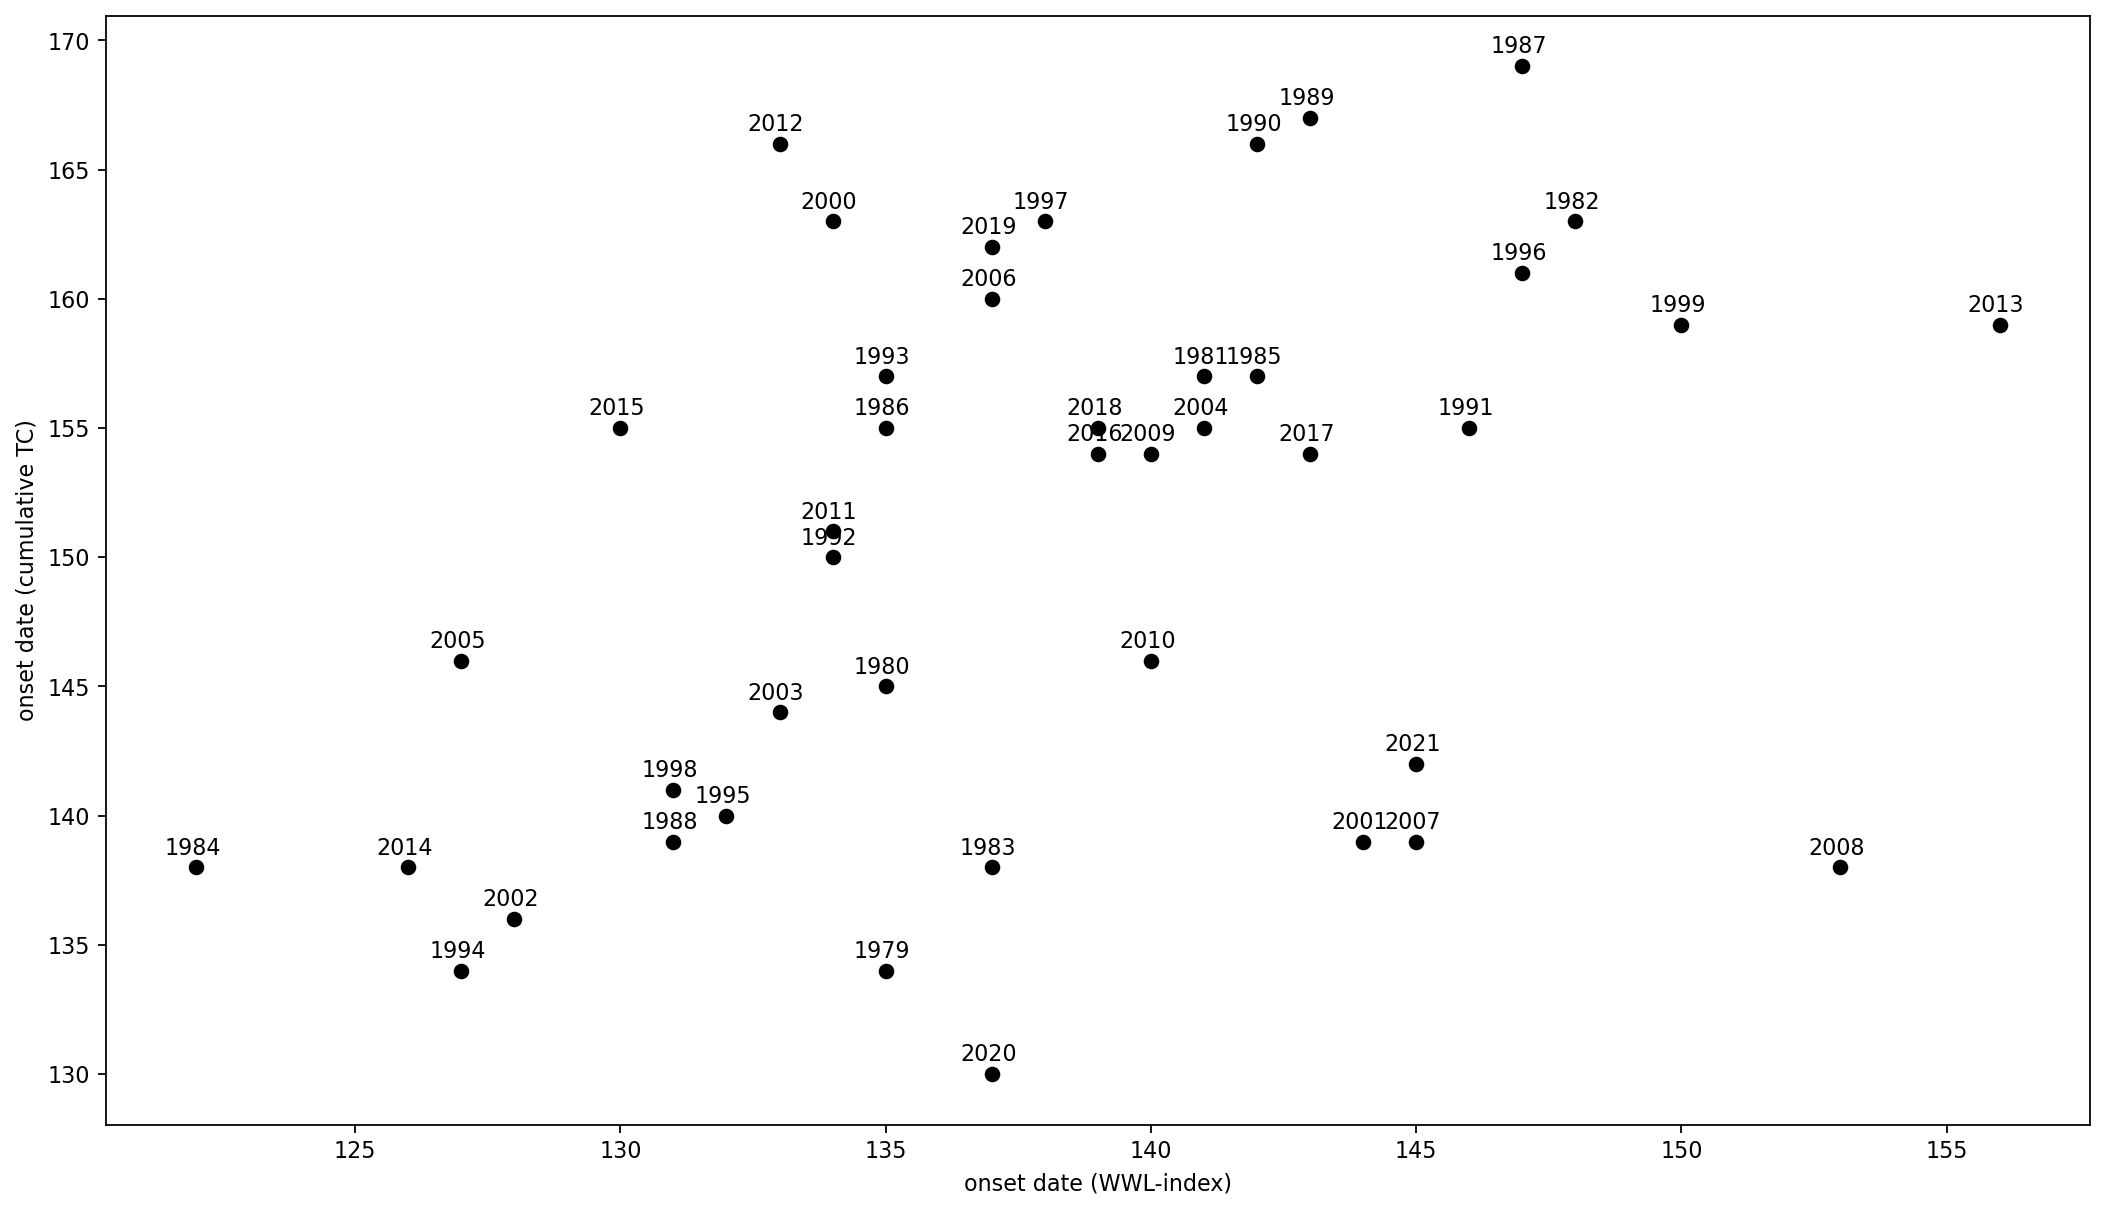

In [19]:
#print(onset_date_index)
tmp = np.argmax(np.cumsum(occurrence.reshape(43,-1), axis = 1)>30, axis = 1)
print(tmp)
print(np.corrcoef(onset_date_index,tmp))
plt.figure(figsize=(16,9),dpi=160)
for i,index in enumerate(np.argsort(tmp)):
    #pass
    plt.scatter(onset_date_index[i],tmp[i], color = "k")
    plt.annotate(index+1979, (onset_date_index[i]-0.6, tmp[i]+0.5))
plt.xlabel("onset date (WWL-index)")
plt.ylabel("onset date (cumulative TC)")

In [ ]:
def stream_function(v, rho, z):
    ubar = (u[1:,:] + u[:-1,:])/2
    rhobar = (rho[1:] + rho[:-1])/2
    delta_z = np.abs(np.diff(z))
    delta_psi = np.ma.dot(np.diag(delta_z*rhobar), ubar)
    psi = np.zeros_like(u)
    
    for i in range(psi.shape[0]):
        if i == 0:
            pass
        else:
            psi[i] = delta_psi[i-1] + psi[i-1]
    return psi